In [167]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import numpy as np
import umap

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler, KBinsDiscretizer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFECV

from pyod.models.copod import COPOD

import warnings
warnings.filterwarnings("ignore")

In [168]:
data_train = pd.read_csv("train.csv")
data_train.drop(columns=["Loan_ID", "Gender"], inplace=True)

data_test = pd.read_csv("test.csv")
data_test.drop(columns=["Gender"], inplace=True)

data_submission = pd.DataFrame({"Loan_ID" : data_test.pop("Loan_ID")})
data_train.head()

,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [169]:
data_train.shape

(614, 11)

In [170]:
data_train.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [171]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Married            611 non-null    object 
 1   Dependents         599 non-null    object 
 2   Education          614 non-null    object 
 3   Self_Employed      582 non-null    object 
 4   ApplicantIncome    614 non-null    int64  
 5   CoapplicantIncome  614 non-null    float64
 6   LoanAmount         592 non-null    float64
 7   Loan_Amount_Term   600 non-null    float64
 8   Credit_History     564 non-null    float64
 9   Property_Area      614 non-null    object 
 10  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(6)
memory usage: 52.9+ KB


In [172]:
data_train["ApplicantIncome"] = data_train["ApplicantIncome"].astype("float64")
data_test["ApplicantIncome"] = data_test["ApplicantIncome"].astype("float64")

data_train["Credit_History"] = data_train["Credit_History"].replace({1.0 : "Yes", 0.0 : "No"}).astype("object") # Convert credit history to categorical (there is only 0 and 1)

In [173]:
(data_train.isnull().mean() * 100)

Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

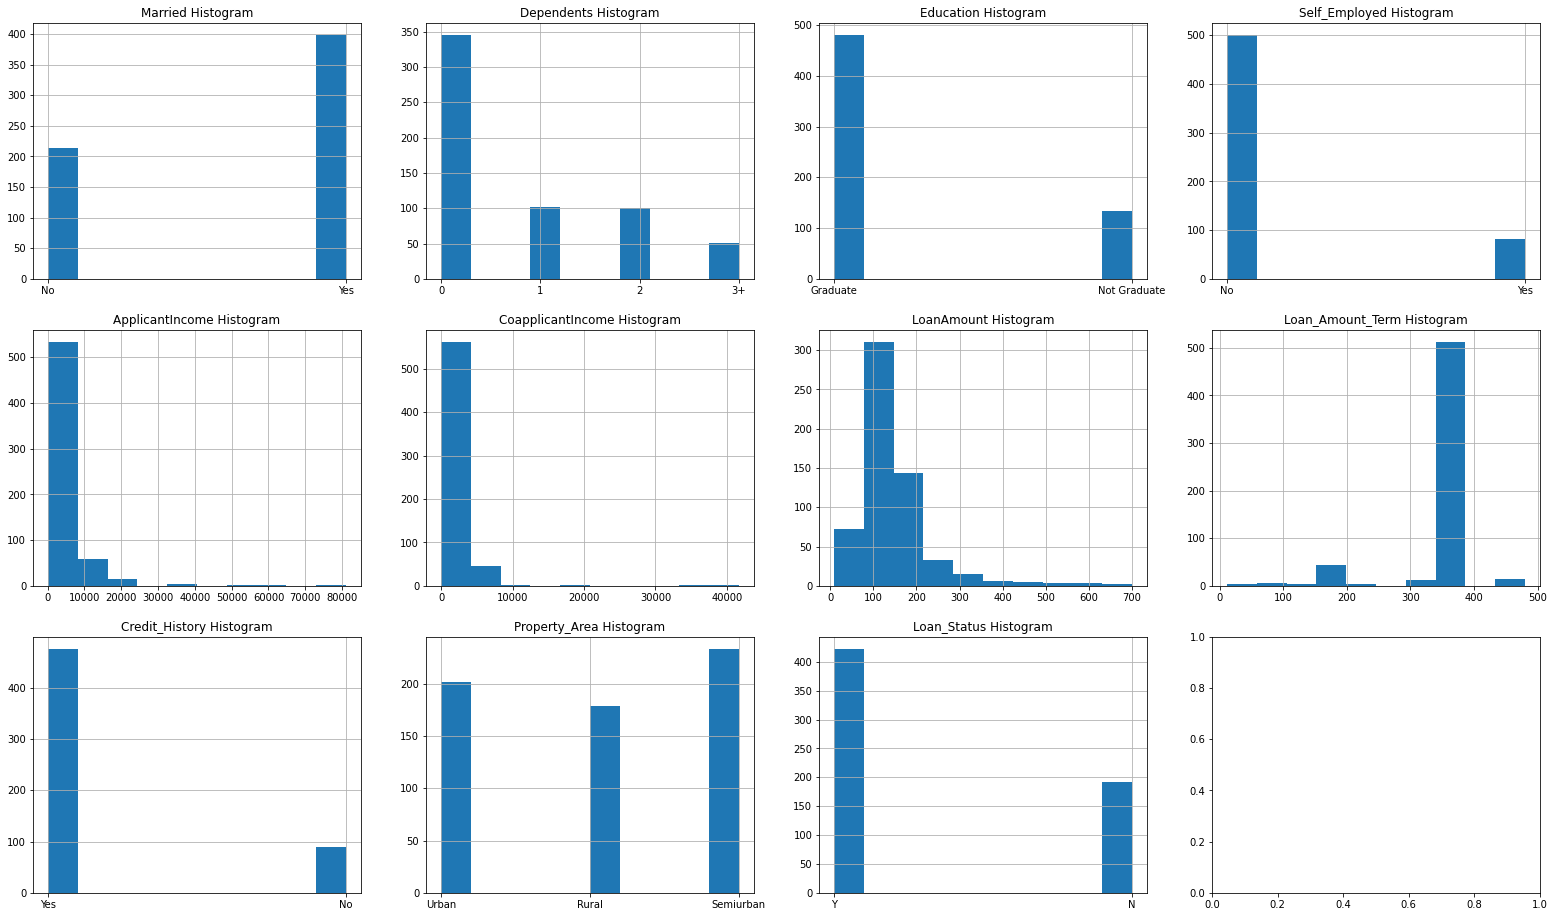

In [174]:
fig, axes = plt.subplots(3, 4, figsize=(27, 16))
r_idx = 0
c_idx = 0
for col in data_train:
    axes[r_idx][c_idx].set_title(f"{col} Histogram")
    data_train[col].hist(ax=axes[r_idx][c_idx])
    c_idx += 1
    if c_idx >= 4:
        r_idx += 1
        c_idx = 0

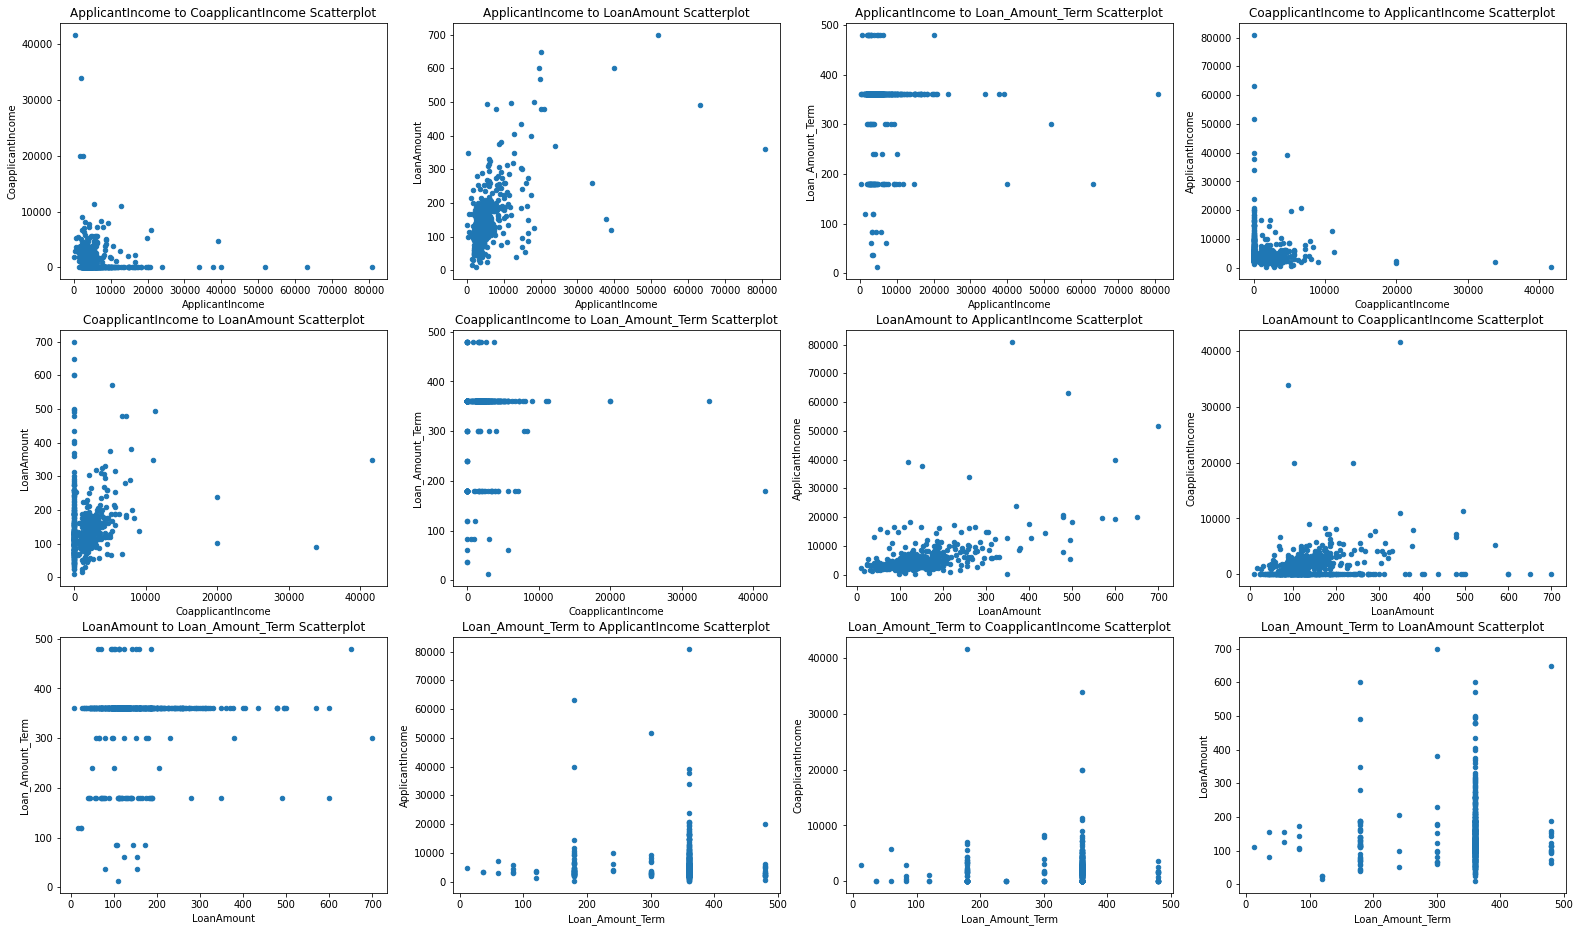

In [175]:
fig, axes = plt.subplots(3, 4, figsize=(27, 16))
r_idx = 0
c_idx = 0
float_cols = list(data_train.select_dtypes(include="float64"))
for col_1 in float_cols:
    for col_2 in float_cols:
        if col_1 == col_2:
            continue
        axes[r_idx][c_idx].set_title(f"{col_1} to {col_2} Scatterplot")
        data_train.plot.scatter(x=col_1, y=col_2, ax=axes[r_idx][c_idx])
        c_idx += 1
        if c_idx >= 4:
            r_idx += 1
            c_idx = 0

In [176]:
si = SimpleImputer(strategy="most_frequent")
for col in data_train.select_dtypes(include="object"):
    try:
        if data_train[col].isnull().sum() > 0:
            data_train[col] = si.fit_transform(data_train[col].values.reshape(-1, 1))
            data_test[col] = si.transform(data_test[col].values.reshape(-1, 1)) 
    except Exception as _:
        pass

In [177]:
ii = IterativeImputer(estimator=lgb.LGBMRegressor(n_jobs=-1))
for col in data_train.select_dtypes(include="float64"):
    data_train[col] = ii.fit_transform(pd.DataFrame({"" : data_train[col]}))
    data_test[col] = ii.transform(pd.DataFrame({"" : data_test[col]})) 

In [178]:
def encode_cat(df_train, df_test):
    cat_nominal = ["Married", "Education", "Self_Employed", "Credit_History", "Property_Area"]
    oe = OrdinalEncoder()
    df_train = pd.get_dummies(df_train, columns=cat_nominal, drop_first=True)
    df_test = pd.get_dummies(df_test, columns=cat_nominal, drop_first=True)
    df_train["Loan_Status"] = oe.fit_transform(df_train["Loan_Status"].values.reshape(-1, 1)).astype("uint8")
    df_train["Dependents"] = oe.fit_transform(df_train["Dependents"].values.reshape(-1, 1)).astype("uint8")
    df_test["Dependents"] = oe.fit_transform(df_test["Dependents"].values.reshape(-1, 1)).astype("uint8")
    return df_train, df_test

In [179]:
data_train, data_test = encode_cat(data_train, data_test)

In [180]:
data_train["TotalApplicantIncome"] = data_train["ApplicantIncome"] + data_train["CoapplicantIncome"]
data_test["TotalApplicantIncome"] = data_test["ApplicantIncome"] + data_test["CoapplicantIncome"]

disc = KBinsDiscretizer(n_bins=5, encode="ordinal", strategy="quantile")
for col in data_train.select_dtypes(include="float64"):
    data_train[f"{col}_Level"] = disc.fit_transform(data_train[[col]])
    data_test[f"{col}_Level"] = disc.fit_transform(data_test[[col]])
data_train.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Credit_History_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalApplicantIncome,ApplicantIncome_Level,CoapplicantIncome_Level,LoanAmount_Level,Loan_Amount_Term_Level,TotalApplicantIncome_Level
0,0,5849.0,0.0,146.412162,360.0,1,0,0,0,1,0,1,5849.0,2.0,0.0,1.0,1.0,1.0
1,1,4583.0,1508.0,128.000000,360.0,0,1,0,0,1,0,0,6091.0,1.0,0.0,1.0,1.0,1.0
2,0,3000.0,0.0,66.000000,360.0,1,1,0,1,1,0,1,3000.0,0.0,0.0,0.0,1.0,0.0
3,0,2583.0,2358.0,120.000000,360.0,1,1,1,0,1,0,1,4941.0,0.0,1.0,1.0,1.0,1.0
4,0,6000.0,0.0,141.000000,360.0,1,0,0,0,1,0,1,6000.0,2.0,0.0,1.0,1.0,1.0


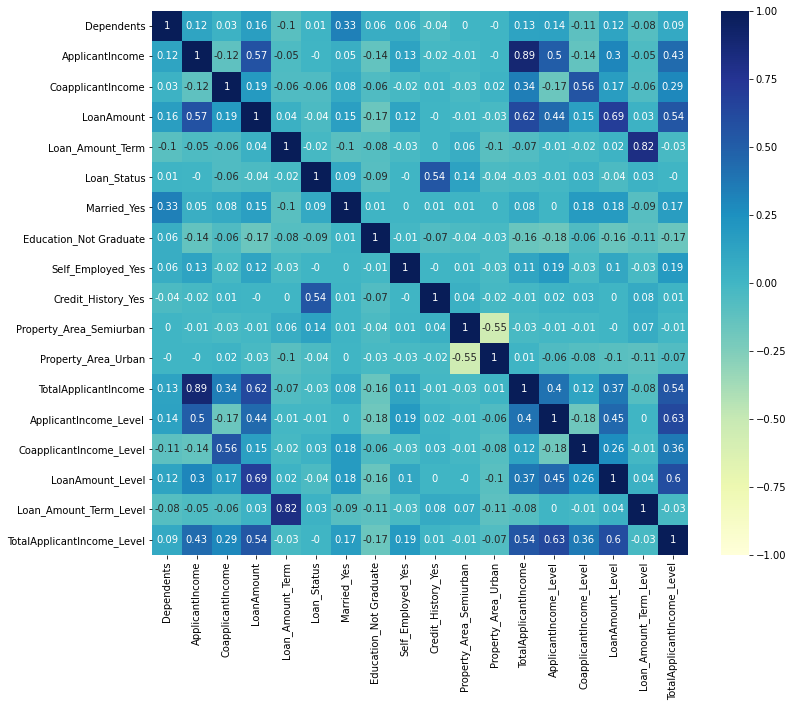

In [181]:
fig, ax = plt.subplots(figsize=(12, 10))
ax = sns.heatmap(data_train.corr(method="pearson").round(2), annot=True, vmin=-1, vmax=1, cmap="YlGnBu")

In [182]:
data_train_y = data_train.pop("Loan_Status")

In [183]:
mms = MinMaxScaler()
data_train = pd.DataFrame(data=mms.fit_transform(data_train), columns=data_train.columns)
data_test = pd.DataFrame(data=mms.transform(data_test), columns=data_test.columns)
data_train.head()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Married_Yes,Education_Not Graduate,Self_Employed_Yes,Credit_History_Yes,Property_Area_Semiurban,Property_Area_Urban,TotalApplicantIncome,ApplicantIncome_Level,CoapplicantIncome_Level,LoanAmount_Level,Loan_Amount_Term_Level,TotalApplicantIncome_Level
0,0.000000,0.070489,0.000000,0.198860,0.74359,0.0,0.0,0.0,1.0,0.0,1.0,0.055394,1.0,0.0,0.5,1.0,0.5
1,0.333333,0.054830,0.036192,0.172214,0.74359,1.0,0.0,0.0,1.0,0.0,0.0,0.058435,0.5,0.0,0.5,1.0,0.5
2,0.000000,0.035250,0.000000,0.082489,0.74359,1.0,0.0,1.0,1.0,0.0,1.0,0.019583,0.0,0.0,0.0,1.0,0.0
3,0.000000,0.030093,0.056592,0.160637,0.74359,1.0,1.0,0.0,1.0,0.0,1.0,0.043980,0.0,1.0,0.5,1.0,0.5
4,0.000000,0.072356,0.000000,0.191027,0.74359,0.0,0.0,0.0,1.0,0.0,1.0,0.057292,1.0,0.0,0.5,1.0,0.5


In [184]:
copod = COPOD(contamination=0.05, n_jobs=1)
copod.fit(data_train)

COPOD(contamination=0.05, n_jobs=1)

In [185]:
n_components = 3
umap_clf = umap.UMAP(n_components=n_components, n_jobs=-1)
data_train_umap = pd.DataFrame(data=umap_clf.fit_transform(data_train), columns=[f"C{i}" for i in range(n_components)])
data_test_umap = pd.DataFrame(data=umap_clf.transform(data_test), columns=[f"C{i}" for i in range(n_components)])

In [186]:
def visualize_3d(title, c, data):
    fig = plt.figure(figsize=(11, 8))
    ax = fig.add_subplot(projection='3d')
    ax.set_title(title)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    ax.scatter(data["C0"], data["C1"], data["C2"], c=c, cmap="seismic", marker=".", linewidths=1, alpha=0.6)

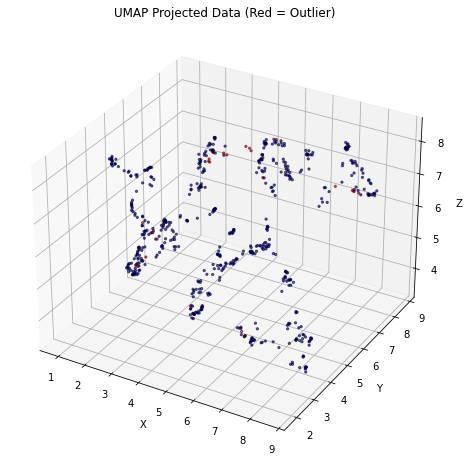

In [187]:
visualize_3d("UMAP Projected Data (Red = Outlier)", copod.labels_, data_train_umap)

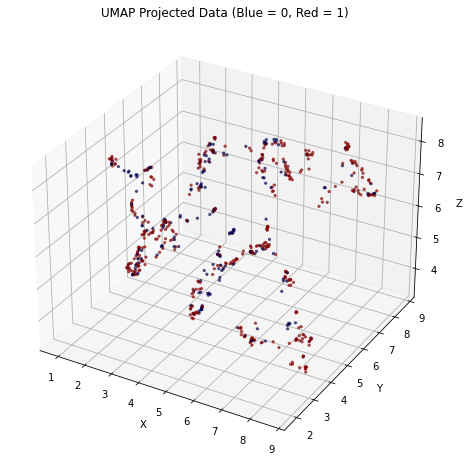

In [188]:
visualize_3d("UMAP Projected Data (Blue = 0, Red = 1)", data_train_y, data_train_umap)

In [189]:
params = {
    "random_state" : [0],
    "n_jobs" : [-1],
    "learning_rate" : [0.01, 0.02, 0.03, 0.04, 0.05],
    "num_iterations" : [100, 150, 200, 250, 300],
    "max_depth" : [3, 6, 9, 12, -1],
    "num_leaves" : [15, 31, 63, 127, 255]
}
skfold = StratifiedKFold()
gs = GridSearchCV(estimator=lgb.LGBMClassifier(), param_grid=params, scoring=["accuracy", "f1", "roc_auc"], refit="accuracy", cv=skfold, n_jobs=-1)
_ = gs.fit(data_train, data_train_y)

In [190]:
print(f"""Best Params: 
{gs.best_params_}
Best Score:
{gs.best_score_}""")

Best Params: 
{'learning_rate': 0.01, 'max_depth': 3, 'n_jobs': -1, 'num_iterations': 100, 'num_leaves': 15, 'random_state': 0}
Best Score:
0.809462881514061


In [191]:
def cv_score(scoring):
    return np.mean(cross_val_score(estimator=lgb.LGBMClassifier(), X=data_train, y=data_train_y, scoring=scoring, cv=skfold, n_jobs=-1))
    
print(f"""Cross-validation scores 
Accuracy: {cv_score("accuracy")}
F1: {cv_score("f1")}
ROC_AUC: {cv_score("roc_auc")}""")

Cross-validation scores 
Accuracy: 0.7589097694255631
F1: 0.8325422963957188
ROC_AUC: 0.7586880285177499


In [192]:
X_train, X_test, y_train, y_test = train_test_split(data_train, data_train_y, test_size=0.5, random_state=0, stratify=data_train_y)

In [193]:
reg_final = lgb.LGBMClassifier(**gs.best_params_)

In [194]:
print(f"""Train/test set scores
Train: {reg_final.fit(X_train, y_train).score(X_train, y_train)}
Test: {reg_final.fit(X_train, y_train).score(X_test, y_test)}""")

Train/test set scores
Train: 0.7915309446254072
Test: 0.8273615635179153


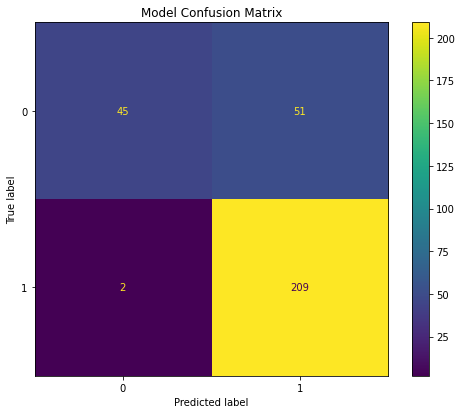

In [195]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
ax.set_title("Model Confusion Matrix")
plot_confusion_matrix(estimator=reg_final.fit(X_train, y_train), X=X_test, y_true=y_test, ax=ax)

In [196]:
reg_final.fit(data_train, data_train_y)

LGBMClassifier(learning_rate=0.01, max_depth=3, num_iterations=100,
               num_leaves=15, random_state=0)

<AxesSubplot:title={'center':'Model Feature Importance'}>

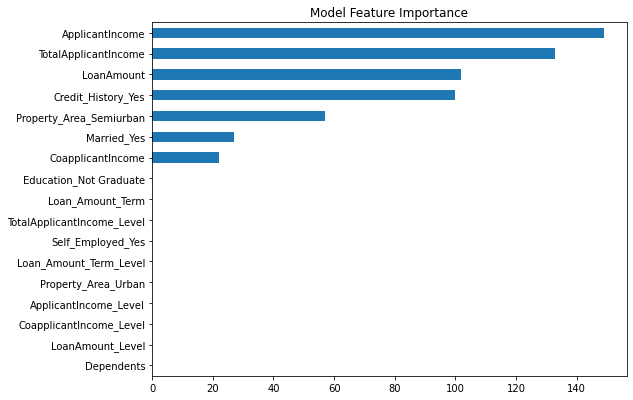

In [197]:
fig, ax = plt.subplots(figsize=(8.5, 6.5))
ax.set_title("Model Feature Importance")
feature_importances = pd.Series(data=reg_final.feature_importances_, index=data_train.columns).sort_values()
feature_importances.plot.barh(ax=ax)

In [198]:
rfe = RFECV(reg_final, cv=skfold, scoring="accuracy", n_jobs=-1)
rfe.fit(data_train, data_train_y)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(learning_rate=0.01, max_depth=3,
                               num_iterations=100, num_leaves=15,
                               random_state=0),
      n_jobs=-1, scoring='accuracy')

In [199]:
pd.DataFrame({"feature" : data_train.columns, "selected" : rfe.support_, "score" : rfe.ranking_}).sort_values(by="score", ascending=True)

,feature,selected,score
8,Credit_History_Yes,True,1
1,ApplicantIncome,True,1
3,LoanAmount,True,1
11,TotalApplicantIncome,True,1
9,Property_Area_Semiurban,False,2
5,Married_Yes,False,3
2,CoapplicantIncome,False,4
16,TotalApplicantIncome_Level,False,5
15,Loan_Amount_Term_Level,False,6
14,LoanAmount_Level,False,7


In [200]:
data_submission["Loan_Status"] = pd.Series(reg_final.predict(data_test)).replace({0 : "N", 1 : "Y"})
data_submission.sample(5).head()

,Loan_ID,Loan_Status
287,LP002584,Y
120,LP001627,Y
139,LP001771,N
166,LP001933,N
236,LP002321,N


In [201]:
data_submission.to_csv("results.csv", index=False)